# open h5

In [34]:
# laod h5
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py

pathName = "/home/spinnaker/2020-11_brainhack_Project7/dev/Results/20201203/VAbenchmarks_exc_spinnaker_20201203-144950.h5"

#h5 = h5py.File(pathName,'r')

#list(h5.keys()) #acts as python dictionary


In [38]:
import neo
with neo.NixIO('filename') as io:
    block = io.read_block()
    
# start from here to open nix-hdf5

# open pickle file

In [30]:
import pickle 

def getPklData(pathData):
    fileHandle = open(pathData, 'rb')
    neoObj = pickle.load(fileHandle)
    #segments = neoObj.segments[0]
    #inputSpikes = segments.spiketrains
    #voltage = segments.analogsignals[0]
    return neoObj

pathData = "/home/spinnaker/2020-11_brainhack_Project7/dev/Results/20201203/VAbenchmarks_exc_spinnaker_20201203-161750.pkl"
neoObj = getPklData(pathData)


# define plot function

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot(signal, spikes, alpha=.2):
    fig_settings = {
        'lines.linewidth': 0.5,
        'axes.linewidth': 0.5,
        'axes.labelsize': 'small',
        'legend.fontsize': 'small',
        'font.size': 14
    }
    plt.rcParams.update(fig_settings)

    #n_panels = sum(a.shape[1] for a in signal.segments[0].analogsignals) + 1
    n_panels = len(signal.segments[0].analogsignals) +1 
    fig, axs = plt.subplots(n_panels, 1, figsize=(15, 21))

    def plot_spiketrains(ax, segment):
        for spiketrain in segment.spiketrains[:100]:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.plot(spiketrain, y, '.')
            ax.set_ylabel(segment.name)
            #plt.setp(plt.gca().get_xticklabels(), visible=False)

    def plot_signal(ax, signal, index, colour='b'):
        label = "Neuron %d" % signal.annotations['source_ids'][index]
        ax.plot(signal.times, signal[:, index], colour, label=label, alpha=alpha)
        ax.set_ylabel("%s (%s)" % (signal.name, signal.units._dimensionality.string))
        #plt.setp(plt.gca().get_xticklabels(), visible=False)
        #plt.legend()

    plot_spiketrains(axs[0], spikes.segments[0])
    #plot_spiketrains(axs[1], all_spikes.segments[0])
    for i_panel, array in enumerate(signal.segments[0].analogsignals):
        for i in range(array.shape[1]):
            ax = axs[i_panel+1]
            plot_signal(ax, array, i, colour='bg'[i_panel % 2])
    ax.set_xlabel("time (%s)" % array.times.units._dimensionality.string)
    #plt.setp(plt.gca().get_xticklabels(), visible=True)
    return fig, axs



# plot pkl file

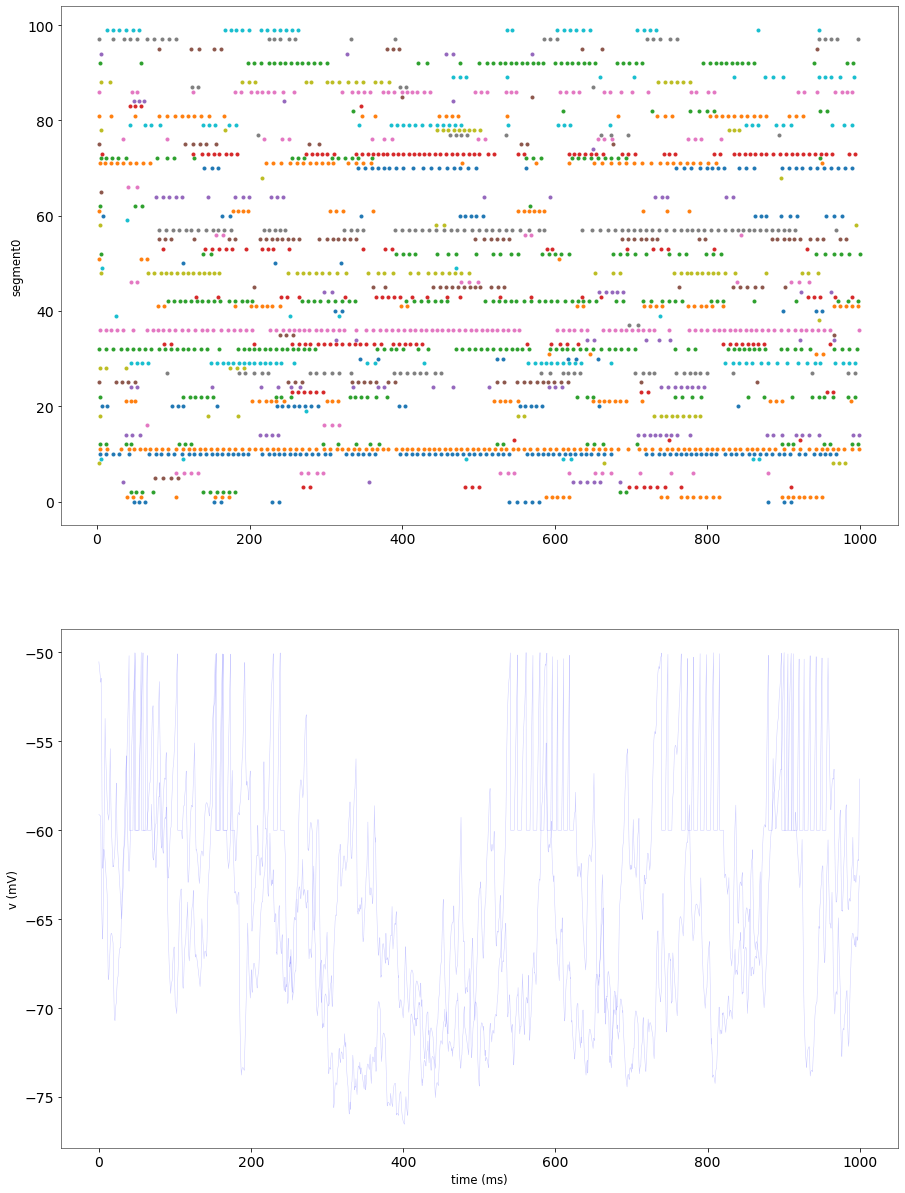

In [31]:
fig, axs = plot(neoObj,neoObj)